In [ ]:
!pip install opacus # Colab
!pip install medmnist # Colab
from opacus import PrivacyEngine
import medmnist
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=84b824e05ecc1096b56dfa2c4daf45b34950ae8847bb65ee9f738ceae3f1bef8
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


# 1 Differentially private model training

## Functionalities for subtasks

### Dataloader

In [ ]:
def create_dataloader(args):
    # Hyperparameters
    Dataset = args.Dataset
    splits = args.splits
    batch_size = args.batch_size
    num_workers = args.num_workers
    normalize_mean = args.normalize_mean
    normalize_std = args.normalize_std

    # Define transformations for the data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ])

    # Download dataset and split
    ###### TODO ##########
    try:  # TODO: For CIFAR10 Maybe better to use IF Satetement
      dataset = Dataset(root='./data', train=True, download=True,
                        transform=transform)
      splits = [int(splits["train"] * len(dataset)),
                int(splits["val"] * len(dataset)),
                int(splits["test"] * len(dataset))]
      train_dataset, val_dataset, test_dataset = random_split(dataset, splits)
    except: # For Medmnist Datasets
      train_dataset = Dataset(root="./data", split='train', download=True,
                              transform=transform, as_rgb=True)
      val_dataset = Dataset(root="./data", split='val', download=True,
                              transform=transform, as_rgb=True)
      test_dataset = Dataset(root="./data", split='test', download=True,
                              transform=transform, as_rgb=True)



    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

def sample_data(dataloader, num_samples=20):
    # Get dataset samples
    images, labels = next(iter(dataloader))

    # Figure appearance
    cols = 10
    rows = num_samples // cols

    for row in range(rows):
        fig, axes = plt.subplots(1, cols, figsize=(cols, 4))

        for index, ax in enumerate(axes):
            # Get image and label, normalize to (0, 1), transpose
            image, label = images[index + row*cols].cpu().numpy(), labels[index + row*cols].cpu().numpy()
            image -= image.min()
            image /= image.max()
            image = image.transpose(1, 2, 0)

            # Show image and label
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{label}", fontsize=8)

### Model

In [ ]:
def create_model(args):
    # Hyperparameters
    Model = args.Model
    device = args.device
    pretrained = args.pretrained
    num_classes = args.num_classes

    # Get model
    weights = None
    if pretrained:
        weights = "DEFAULT"
    model = Model(weights=weights).to(device)

    # Remove BatchNorm layers (not compatible with DP)
    def _remove_batchnorm(module):
        for child_name, child_module in module.named_children():
            if isinstance(child_module, nn.BatchNorm2d):
                setattr(module, child_name, nn.Identity())
            else:
                _remove_batchnorm(child_module)
    _remove_batchnorm(model)

    # Modify FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc.reset_parameters()

    return model

### Training


In [ ]:
def training(args, train_loader, val_loader, model, use_privacy_engine=False):
    # Start time
    start_time = time.time()

    # Hyperparameters
    device = args.device
    print(f"Device: {device}")
    criterion = args.criterion
    optimizer = args.optimizer
    lr = args.lr
    epochs = args.epochs
    target_epsilon = args.target_epsilon
    target_delta = args.target_delta
    noise_multiplier = args.noise_multiplier
    max_grad_norm = args.max_grad_norm
    use_targets = args.use_targets

    # Model setup
    model = model.to(device)
    model.train()

    # Optimizer setup
    optimizer = optimizer(model.parameters(), lr=lr)

    # DP setup
    if use_privacy_engine:
        privacy_engine = PrivacyEngine()
        if use_targets: # make private based on target_epsilon and target_delta
            model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
                module=model,
                optimizer=optimizer,
                data_loader=train_loader,
                target_epsilon=target_epsilon,
                target_delta=target_delta,
                epochs=epochs,
                max_grad_norm=max_grad_norm,
            )
        if not use_targets: # make private based on noise_multiplier
            model, optimizer, train_loader = privacy_engine.make_private(
                module=model,
                optimizer=optimizer,
                data_loader=train_loader,
                noise_multiplier=noise_multiplier,
                max_grad_norm=max_grad_norm,
            )

    # Evaluation variables
    loss_list, val_loss_list, acc_list = list(), list(), list()

    for epoch in range(epochs):
        # Evaluation variables
        loss_running, val_loss_running, acc_running = 0, 0, 0

        # Loop
        train_loop = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100,
                          desc=f"Training-Epoch {epoch+1}/{epochs}")

        # Start training
        for i, (inputs, labels) in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            if len(labels.size())!=1:
                  labels = labels.squeeze(dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_running += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update tqdm
            train_loop.set_postfix(train_loss = f"{loss_running/(i+1):.5f}")

        loss_list.append(loss_running/len(train_loader))

        with torch.no_grad():
            # Loop
            val_loop = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100,
                            desc=f"Validation-Epoch {epoch+1}/{epochs}")

            # Start validation
            for i, (inputs, labels) in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                if len(labels.size())!=1:
                  labels = labels.squeeze(dim=1)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_running += loss.item()

                # Metrics
                labels = labels.detach().cpu()
                outputs = torch.argmax(outputs.detach().cpu(), axis=1)
                acc_running += np.mean(outputs.numpy() == labels.numpy())

                # Update tqdm
                val_loop.set_postfix(val_loss = f"{val_loss_running/(i+1):.5f}")

            val_loss_list.append(val_loss_running/len(val_loader))
            acc_list.append(acc_running/len(val_loader))

    # Results
    print(f"Training Loss: {loss_list[-1]:.5f}, Validation Loss: {val_loss_list[-1]:.5f}, Validation Accuracy: {acc_list[-1] * 100:.2f}%")

    # DP results
    if use_privacy_engine:
        # Compute privacy budget
        epsilon = privacy_engine.get_epsilon(target_delta)
        if use_targets:
            print(f"Epsilon = {epsilon:.2f}, Target-Epsilon = {target_epsilon}, Target-Delta = {target_delta}")
        if not use_targets:
            print(f"Epsilon = {epsilon:.2f}, Target-Delta = {target_delta}")

    # Elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

    # Visual feedback
    epochs_list = np.arange(epochs) + 1
    fig = plt.figure(figsize=(5, 4))
    plt.plot(epochs_list, loss_list, label="Training Loss")
    plt.plot(epochs_list, val_loss_list, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(epochs_list, epochs_list)
    plt.grid(axis="x")
    plt.close()

    return model, loss_list, val_loss_list, acc_list, fig

### Test

In [ ]:
def test(args, test_loader, model):
    # Hyperparameters
    device = args.device
    print(f"Device: {device}")
    criterion = args.criterion

    # Model setup
    model = model.to(device)
    model.eval()

    # Evaluation variables
    loss_running, acc_running = 0, 0

    with torch.no_grad():
        # Loop
        test_loop = tqdm(enumerate(test_loader), total=len(test_loader), ncols=100,
                            desc="Test-Loop")

        for i, (inputs, labels) in test_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            if len(labels.size()) != 1:
              labels = labels.squeeze(dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_running += loss.item()

            # Metrics
            labels = labels.detach().cpu()
            outputs = torch.argmax(outputs.detach().cpu(), axis=1)
            acc_running += np.mean(outputs.numpy() == labels.numpy())

            # Update tqdm
            test_loop.set_postfix(test_loss = f"{loss_running/(i+1):.5f}")

        loss = loss_running/len(test_loader)
        acc = acc_running/len(test_loader)

    print(f"Test Loss: {loss:.5f}, Test Accuracy: {acc * 100:.2f}%")

    return loss, acc

### Save/load

In [ ]:
def save_model(model, name=''):
    path = "./models"
    if not os.path.exists(path):
        os.makedirs(path)
    model_path = os.path.join(path, name + '.pth')
    torch.save(model, model_path)
    print('Model saved.')

def load_model(name=''):
    path = "./models"
    path = os.path.join(path, 'models', name + '.pth')
    model = torch.load(path)
    print('Model loaded.')
    return model

def save_stats(stats, name=''):
    path = "./results"
    if not os.path.exists(path):
        os.makedirs(path)
    stats_path = os.path.join(path, name + '_stats')
    np.savez(stats_path, stats)
    with open(stats_path + ".txt", 'w') as file:
        for key, value in stats.items():
            file.write(f"{key}: {value}\n")
    print('Stats saved.')

def save_fig(fig, name=''):
    path = "./results"
    if not os.path.exists(path):
        os.makedirs(path)
    fig_path = os.path.join(path, name + '_plot')
    plt.figure(fig)
    plt.savefig(fig_path + ".png", dpi=150, bbox_inches="tight")
    plt.close()
    print('Figure saved.')

### Additional information
$\varepsilon$-differential privacy:
$$\frac{\mathrm{Pr}\left[\mathcal{A}(D_1)\in\mathcal{S}\right]}{\mathrm{Pr}\left[\mathcal{A}(D_2)\in\mathcal{S}\right]}\leq\mathrm{e}^\varepsilon$$
$\varepsilon$-$\delta$-differential privacy:
$$\mathrm{Pr}\left[\mathcal{A}(D_1)\in\mathcal{S}\right]\leq\mathrm{e}^\varepsilon\cdot{\mathrm{Pr}\left[\mathcal{A}(D_2)\in\mathcal{S}\right]}+\delta$$

Docstring opacus.privacy_engine.PrivacyEngine.make_private:
```python
"""
Add privacy-related responsibilities to the main PyTorch training objects:
model, optimizer, and the data loader.

All of the returned objects act just like their non-private counterparts
passed as arguments, but with added DP tasks.

- Model is wrapped to also compute per sample gradients.
- Optimizer is now responsible for gradient clipping and adding noise to the gradients.
- DataLoader is updated to perform Poisson sampling.

Notes:
    Using any other models, optimizers, or data sources during training
    will invalidate stated privacy guarantees.

Args:
    module: PyTorch module to be used for training
    optimizer: Optimizer to be used for training
    data_loader: DataLoader to be used for training
    noise_multiplier: The ratio of the standard deviation of the Gaussian noise to
        the L2-sensitivity of the function to which the noise is added
        (How much noise to add)
    max_grad_norm: The maximum norm of the per-sample gradients. Any gradient with norm
        higher than this will be clipped to this value.
    batch_first: Flag to indicate if the input tensor to the corresponding module
        has the first dimension representing the batch. If set to True, dimensions on
        input tensor are expected be ``[batch_size, ...]``, otherwise
        ``[K, batch_size, ...]``
    loss_reduction: Indicates if the loss reduction (for aggregating the gradients)
        is a sum or a mean operation. Can take values "sum" or "mean"
    poisson_sampling: ``True`` if you want to use standard sampling required
        for DP guarantees. Setting ``False`` will leave provided data_loader
        unchanged. Technically this doesn't fit the assumptions made by
        privacy accounting mechanism, but it can be a good approximation when
        using Poisson sampling is unfeasible.
    clipping: Per sample gradient clipping mechanism ("flat" or "per_layer" or "adaptive").
        Flat clipping calculates the norm of the entire gradient over
        all parameters, per layer clipping sets individual norms for
        every parameter tensor, and adaptive clipping updates clipping bound per iteration.
        Flat clipping is usually preferred, but using per layer clipping in combination
        with distributed training can provide notable performance gains.
    noise_generator: torch.Generator() object used as a source of randomness for
        the noise
    grad_sample_mode: mode for computing per sample gradients. Determines the
        implementation class for the wrapped ``module``. See
        :class:`~opacus.grad_sample.gsm_base.AbstractGradSampleModule` for more
        details

Returns:
    Tuple of (model, optimizer, data_loader).

    Model is a wrapper around the original model that also computes per sample
        gradients
    Optimizer is a wrapper around the original optimizer that also does
        gradient clipping and noise addition to the gradients
    DataLoader is a brand new DataLoader object, constructed to behave as
        equivalent to the original data loader, possibly with updated
        sampling mechanism. Points to the same dataset object.
"""
```
Docstring opacus.privacy_engine.PrivacyEngine.make_private_with_epsilon:
```python
"""
Version of :meth:`~opacus.privacy_engine.PrivacyEngine.make_private`,
that calculates privacy parameters based on a given privacy budget.

For the full documentation see
:meth:`~opacus.privacy_engine.PrivacyEngine.make_private`

Args:
    module: PyTorch module to be used for training
    optimizer: Optimizer to be used for training
    data_loader: DataLoader to be used for training
    max_grad_norm: The maximum norm of the per-sample gradients. Any gradient with norm
        higher than this will be clipped to this value.
    batch_first: Flag to indicate if the input tensor to the corresponding module
        has the first dimension representing the batch. If set to True, dimensions on
        input tensor are expected be ``[batch_size, ...]``, otherwise
        ``[K, batch_size, ...]``
    loss_reduction: Indicates if the loss reduction (for aggregating the gradients)
        is a sum or a mean operation. Can take values "sum" or "mean"
    poisson_sampling: ``True`` if you want to use standard sampling required
        for DP guarantees. Setting ``False`` will leave provided data_loader
        unchanged. Technically this doesn't fit the assumptions made by
        privacy accounting mechanism, but it can be a good approximation when
        using Poisson sampling is unfeasible.
    clipping: Per sample gradient clipping mechanism ("flat" or "per_layer" or "adaptive").
        Flat clipping calculates the norm of the entire gradient over
        all parameters, per layer clipping sets individual norms for
        every parameter tensor, and adaptive clipping updates clipping bound per iteration.
        Flat clipping is usually preferred, but using per layer clipping in combination
        with distributed training can provide notable performance gains.
    noise_generator: torch.Generator() object used as a source of randomness for
        the noise
    grad_sample_mode: mode for computing per sample gradients. Determines the
        implementation class for the wrapped ``module``. See
        :class:`~opacus.grad_sample.gsm_base.AbstractGradSampleModule` for more
        details

Returns:
    Tuple of (model, optimizer, data_loader).

    Model is a wrapper around the original model that also computes per sample
        gradients
    Optimizer is a wrapper around the original optimizer that also does
        gradient clipping and noise addition to the gradients
    DataLoader is a brand new DataLoader object, constructed to behave as
        equivalent to the original data loader, possibly with updated
        sampling mechanism. Points to the same dataset object.
"""
```

## 1.a Differentially private image classification

### Define hyperparameters

In [ ]:
class args:
    # Machine
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 4

    # Datasets/-loaders
    Dataset = torchvision.datasets.CIFAR10
    num_classes = 10
    batch_size = 64
    normalize_mean = (0.5, 0.5, 0.5)
    normalize_std = (0.5, 0.5, 0.5)
    splits = dict(
        train = 0.7,
        val = 0.15,
        test = 0.15
        )

    # Model
    Model = torchvision.models.resnet18
    pretrained = True

    # Training
    lr = 1e-4
    epochs = 5
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam

    # Privacy
    """
    Just some comments on the intended purpose here:
    use_targets allows to switch between the opacus DP methods make_private
    (use_targets=False) and make_private_with_epsilon (use_targets=True).
    The latter seems to allow more direct control of epsilon and delta, whereas
    the former demands the use of noise_multiplier (less transparent).
    So probably stick to use_targets=True, unless you want to experiment.
    """
    use_targets = True
    target_epsilon = 2.0 # Needed if use_targets=True; upper boundary
    target_delta = 1e-3 # Always needed; used to computes actual epsilon
    noise_multiplier = 1.1 # Needed if use_targets=False; level of randomness
    max_grad_norm = 10.0 # Always needed; cap for gradients

### Load CIFAR-10

100%|██████████| 170498071/170498071 [00:14<00:00, 12142348.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


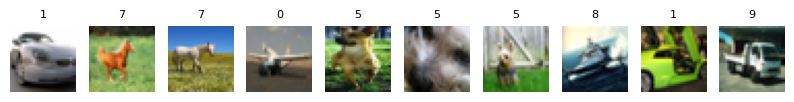

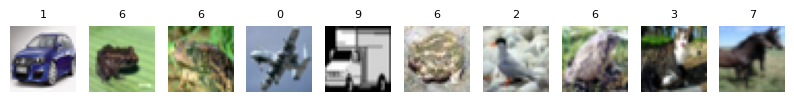

In [ ]:
# Data
train_loader, val_loader, test_loader = create_dataloader(args)
sample_data(train_loader)

### Train ResNet-18 with DP

In [ ]:
# Model
model = create_model(args)

# Training
model, train_loss, val_loss, val_acc, fig = training(
    args, train_loader, val_loader, model,
    use_privacy_engine=True # Use DP privatization during training or not
    )
plt.figure(fig)
plt.show(fig)

# Test
test_loss, test_acc = test(args, test_loader, model)

# Save
name = "resnet18_cifar10_dp"
stats = dict(
    train_loss=train_loss,
    val_loss=val_loss,
    val_acc=val_acc,
    test_loss=test_loss,
    test_acc=test_acc
)
save_stats(stats, name)
save_fig(fig, name)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.2MB/s]


Device: cuda


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


KeyboardInterrupt: 

### Train ResNet-18 without DP

In [ ]:
# Model
model = create_model(args)

# Training
model, train_loss, val_loss, val_acc, fig = training(
    args, train_loader, val_loader, model,
    use_privacy_engine=False # Use DP privatization during training or not
    )
plt.figure(fig)
plt.show(fig)

# Test
test_loss, test_acc = test(args, test_loader, model)

# Save
name = "resnet18_cifar10"
stats = dict(
    train_loss=train_loss,
    val_loss=val_loss,
    val_acc=val_acc,
    test_loss=test_loss,
    test_acc=test_acc
)
save_stats(stats, name)
save_fig(fig, name)



## 1.b Applying DP-SGD to medical data



### Creating class for handling medical datasets

In [ ]:
class args_1bc:
    """
    A class for Training Arguments.

    ...

    General Attributes
    ----------
    Dataset : Dataset
        the Dataset to be analyzed
    num_classes : int
        how many classes does the model should have as output

    Privacy Attributes
    ----------
    use_targets: bool
        whether to use epsilon, delta or noise multiplier
    target_epsilon: float
        epsilon for privacy
    target_delta: float
        delta for privacy
    noise_multiplier: float
        level of randomness
    max_grad_norm: float
        cap for gradients
    """

    def __init__(self, Dataset, num_classes, use_targets=True,
                 target_epsilon=2.0, target_delta=1e-3, noise_multiplier=1.1,
                 max_grad_norm=10.0):
      self.Dataset = Dataset
      self.num_classes = num_classes

       # Privacy
      """
      Just some comments on the intended purpose here:
      use_targets allows to switch between the opacus DP methods make_private
      (use_targets=False) and make_private_with_epsilon (use_targets=True).
      The latter seems to allow more direct control of epsilon and delta, whereas
      the former demands the use of noise_multiplier (less transparent).
      So probably stick to use_targets=True, unless you want to experiment.
      """
      self.use_targets = use_targets
      self.target_epsilon = target_epsilon # Needed if use_targets=True; upper boundary
      self.target_delta = target_delta # used to compute actual epsilon
      self.noise_multiplier = noise_multiplier # Needed if use_targets=False, level of randomness
      self.max_grad_norm = max_grad_norm # Always needed; cap for gradients
    # Machine
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 4

    # Datasets/-loaders
    batch_size = 64
    normalize_mean = (0.5, 0.5, 0.5)
    normalize_std = (0.5, 0.5, 0.5)
    splits = dict(
        train = 0.7,
        val = 0.15,
        test = 0.15
        )

    # Model
    Model = torchvision.models.resnet18
    pretrained = True

    # Training
    lr = 1e-4
    epochs = 5
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam



### Setting up the arguments

In [ ]:
# num_classes is needed to have the desired classification output
path_args = args_1bc(medmnist.PathMNIST, num_classes=9) # 2 Multiclass
derma_args = args_1bc(medmnist.DermaMNIST, num_classes=7)
breast_args = args_1bc(medmnist.BreastMNIST, num_classes=2)  # 1 Binary

### Creating Dataloaders

100%|██████████| 205615438/205615438 [00:50<00:00, 4064889.02it/s] 


Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz


100%|██████████| 19725078/19725078 [00:32<00:00, 605929.49it/s]


Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz


100%|██████████| 559580/559580 [00:01<00:00, 475673.59it/s]

Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz


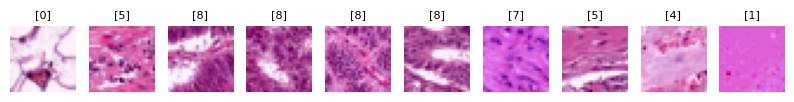

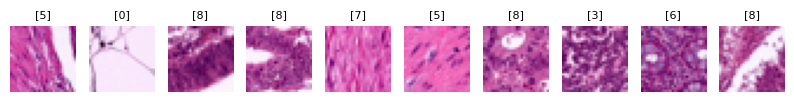

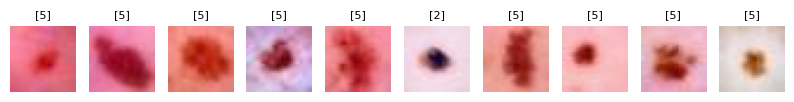

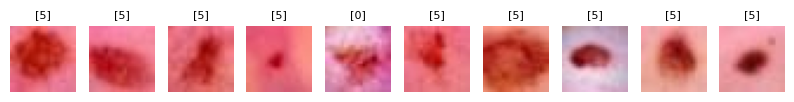

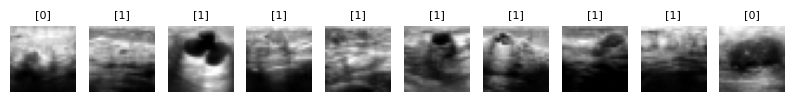

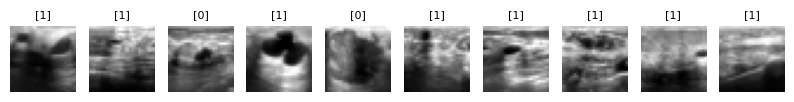

In [ ]:
dataloaders = {"Path": None, "Derma": None, "Breast": None}
arguments = [path_args, derma_args, breast_args]
for i, (key, med_args) in enumerate(zip(dataloaders.keys(), arguments)):
  dataloaders[key] = create_dataloader(med_args)
  sample_data(dataloaders[key][0])

In [ ]:
for (key, (train_loader, val_loader, test_loader)), med_args in zip(dataloaders.items(), arguments):
  # Model
  model = create_model(med_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(args, test_loader, model)

  # Save
  name = f"resnet18_{key}_dp"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda


KeyboardInterrupt: 

In [ ]:
for (key, (train_loader, val_loader, test_loader)), med_args in zip(dataloaders.items(), arguments):
  # Model
  model = create_model(med_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      args, train_loader, val_loader, model,
      use_privacy_engine=False # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(args, test_loader, model)

  # Save
  name = f"resnet18_{key}"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)

# **1c. Analysing the parameters of private learning**

# Setting the parameters


# Make_private_with_epsilon_breast_dataset


Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz


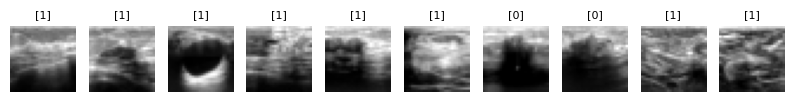

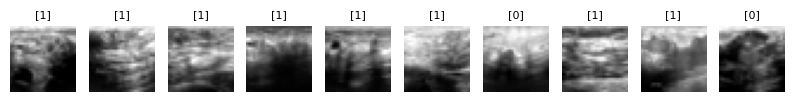

In [ ]:
# Data
train_loader, val_loader, test_loader = create_dataloader(breast_args)
sample_data(train_loader)

Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda


Training-Epoch 1/5:   0%|                                                     | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 16.61it/s, val_loss=0.66686]


Training Loss: 0.68366, Validation Loss: 0.66686, Validation Accuracy: 72.10%
Epsilon = 0.49, Target-Epsilon = 0.5, Target-Delta = 1e-06
Total training time: 00:00:10


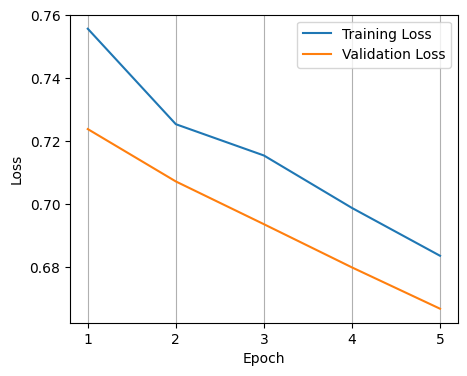

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 17.57it/s, test_loss=0.67233]


Test Loss: 0.67233, Test Accuracy: 66.07%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 15.07it/s, val_loss=0.64491]


Training Loss: 0.61935, Validation Loss: 0.64491, Validation Accuracy: 69.64%
Epsilon = 0.99, Target-Epsilon = 1.0, Target-Delta = 1e-06
Total training time: 00:00:09


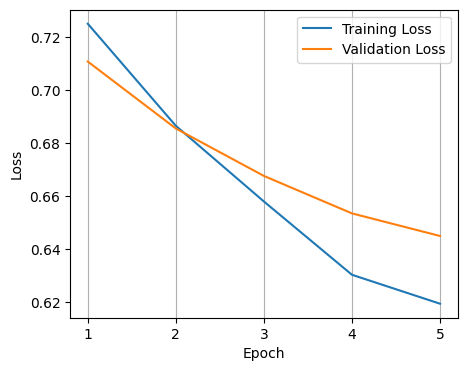

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 22.13it/s, test_loss=0.61364]


Test Loss: 0.61364, Test Accuracy: 73.44%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 14.49it/s, val_loss=0.65480]


Training Loss: 0.59188, Validation Loss: 0.65480, Validation Accuracy: 69.64%
Epsilon = 1.49, Target-Epsilon = 1.5, Target-Delta = 1e-06
Total training time: 00:00:09


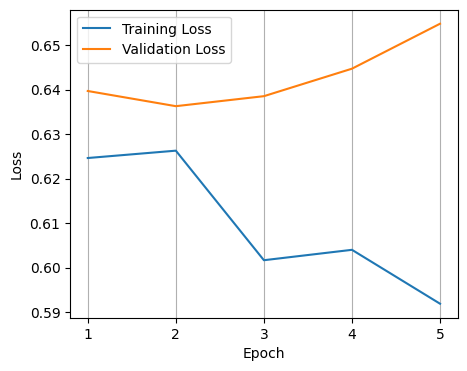

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 19.97it/s, test_loss=0.59811]


Test Loss: 0.59811, Test Accuracy: 73.44%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 15.97it/s, val_loss=0.63522]


Training Loss: 0.62090, Validation Loss: 0.63522, Validation Accuracy: 69.64%
Epsilon = 2.00, Target-Epsilon = 2.0, Target-Delta = 1e-06
Total training time: 00:00:10


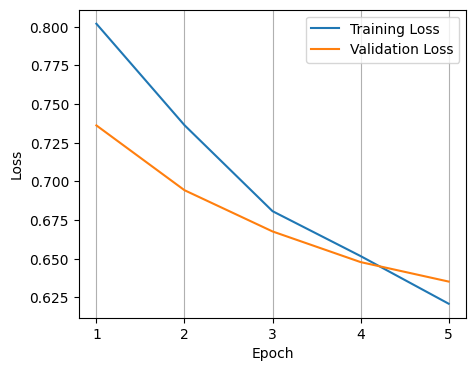

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 19.95it/s, test_loss=0.61857]


Test Loss: 0.61857, Test Accuracy: 73.44%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 12.84it/s, val_loss=0.63804]


Training Loss: 0.63321, Validation Loss: 0.63804, Validation Accuracy: 69.64%
Epsilon = 4.00, Target-Epsilon = 4.0, Target-Delta = 1e-06
Total training time: 00:00:12


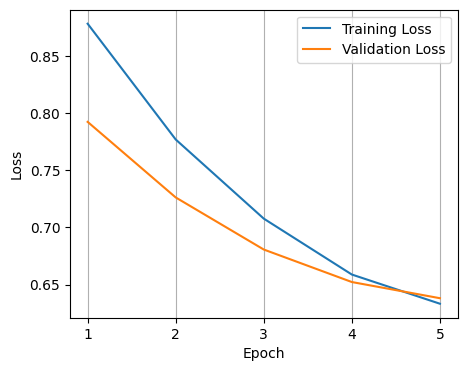

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 20.87it/s, test_loss=0.61820]


Test Loss: 0.61820, Test Accuracy: 73.44%
Stats saved.
Figure saved.


In [ ]:
# parameters
import gc
epsilon_list=[0.5,1.0,1.5,2.0, 4.0]#, 8.0]
delta_list=[1]
max_grad_norm_list=[10.0]
noise_multiplier_list= [1,1.5,2.5,3.5,4.5]

# Make_private_with_epsilon (use_targets=True)
for epsilon in epsilon_list:
  torch.cuda.empty_cache()

  # Model
  breast_args = args_1bc(medmnist.BreastMNIST, num_classes=2, use_targets= True, target_epsilon=epsilon, target_delta=1e-6, max_grad_norm=10.0) # 1 Binary
  train_loader, val_loader, test_loader = create_dataloader(breast_args)
  model = create_model(breast_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      breast_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(breast_args, test_loader, model)

  # Save
  name = "privacy_settings_breast_epsilon"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()




#################### Testing with noise: 10 ########################
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 14.93it/s, val_loss=0.65144]


Training Loss: 0.63444, Validation Loss: 0.65144, Validation Accuracy: 68.86%
Epsilon = 0.31, Target-Delta = 1e-06
Total training time: 00:00:07


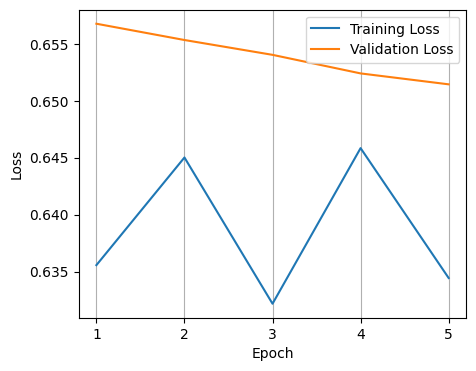

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 20.42it/s, test_loss=0.63827]


Test Loss: 0.63827, Test Accuracy: 68.97%
Stats saved.
Figure saved.
#################### Testing with noise: 1.5 ########################
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 16.66it/s, val_loss=0.63809]


Training Loss: 0.61451, Validation Loss: 0.63809, Validation Accuracy: 69.64%
Epsilon = 3.13, Target-Delta = 1e-06
Total training time: 00:00:07


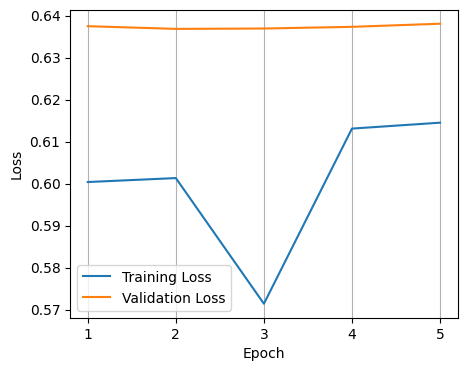

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 13.93it/s, test_loss=0.59550]


Test Loss: 0.59550, Test Accuracy: 73.44%
Stats saved.
Figure saved.
#################### Testing with noise: 2.5 ########################
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 13.24it/s, val_loss=0.66472]


Training Loss: 0.59950, Validation Loss: 0.66472, Validation Accuracy: 69.64%
Epsilon = 1.52, Target-Delta = 1e-06
Total training time: 00:00:07


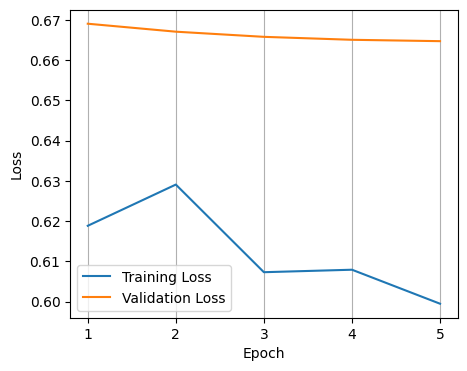

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 16.80it/s, test_loss=0.61203]


Test Loss: 0.61203, Test Accuracy: 73.44%
Stats saved.
Figure saved.
#################### Testing with noise: 3.5 ########################
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 16.56it/s, val_loss=0.65750]


Training Loss: 0.64066, Validation Loss: 0.65750, Validation Accuracy: 68.86%
Epsilon = 1.00, Target-Delta = 1e-06
Total training time: 00:00:07


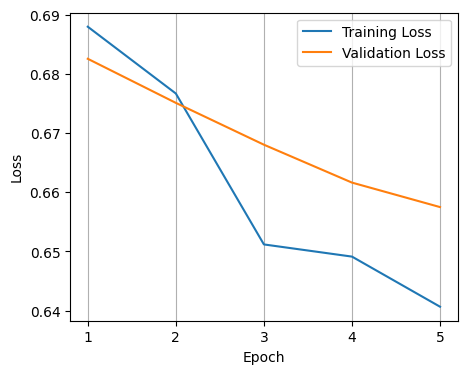

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 19.16it/s, test_loss=0.64285]


Test Loss: 0.64285, Test Accuracy: 67.41%
Stats saved.
Figure saved.
#################### Testing with noise: 4.5 ########################
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████████| 2/2 [00:00<00:00, 17.20it/s, val_loss=0.63930]


Training Loss: 0.63949, Validation Loss: 0.63930, Validation Accuracy: 68.86%
Epsilon = 0.74, Target-Delta = 1e-06
Total training time: 00:00:07


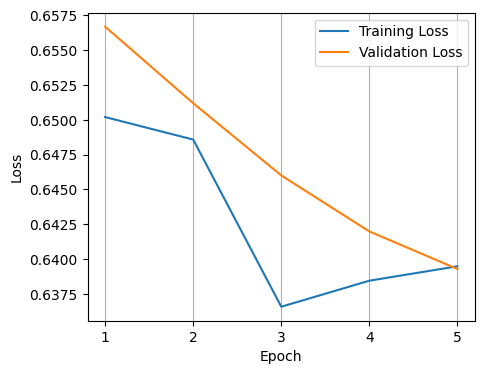

Device: cuda


Test-Loop: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 19.33it/s, test_loss=0.62735]


Test Loss: 0.62735, Test Accuracy: 73.44%
Stats saved.
Figure saved.


In [ ]:
#make_private(use_targets=False)
noise_multiplier_list= [10,1.5,2.5,3.5,4.5]
for noise in noise_multiplier_list:
  print(f"#################### Testing with noise: {noise} ########################")
  torch.cuda.empty_cache()

  # Model
  breast_args = args_1bc(medmnist.BreastMNIST, num_classes=2, use_targets= False, target_delta=1e-6, max_grad_norm=20.0, noise_multiplier= noise) # 1 Binary
  train_loader, val_loader, test_loader = create_dataloader(breast_args)
  model = create_model(breast_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      breast_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(breast_args, test_loader, model)

  # Save
  name = "privacy_settings_breast_noise"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()


# Make_private_epsilon_path_dataset

Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz


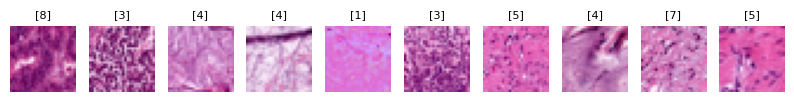

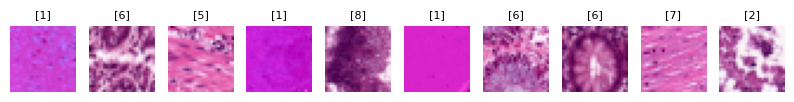

In [ ]:
# Data
train_loader, val_loader, test_loader = create_dataloader(path_args)
sample_data(train_loader)

Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Training-Epoch 1/5:   0%|                                                  | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:03<00:00, 42.91it/s, val_loss=1.27187]


Training Loss: 1.27741, Validation Loss: 1.27187, Validation Accuracy: 58.58%
Epsilon = 0.50, Target-Epsilon = 0.5, Target-Delta = 1e-06
Total training time: 00:12:30


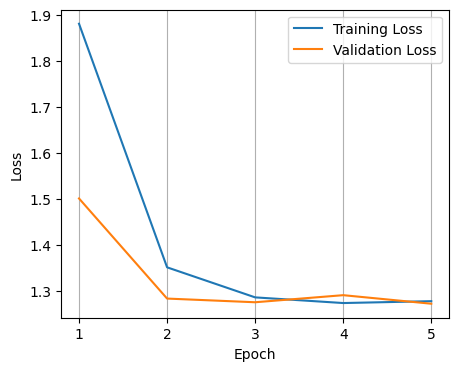

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:03<00:00, 33.85it/s, test_loss=1.08492]


Test Loss: 1.08492, Test Accuracy: 65.50%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:03<00:00, 45.42it/s, val_loss=1.23855]


Training Loss: 1.21470, Validation Loss: 1.23855, Validation Accuracy: 61.85%
Epsilon = 0.99, Target-Epsilon = 1.0, Target-Delta = 1e-06
Total training time: 00:12:32


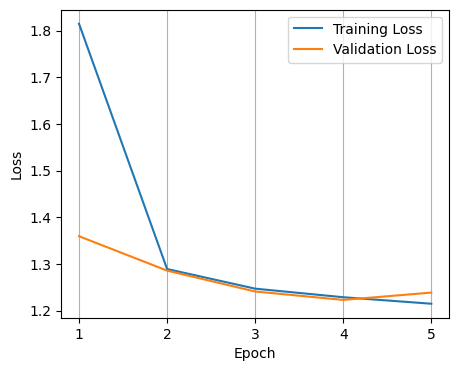

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:03<00:00, 35.16it/s, test_loss=1.10272]


Test Loss: 1.10272, Test Accuracy: 65.50%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:03<00:00, 44.24it/s, val_loss=1.22695]


Training Loss: 1.22085, Validation Loss: 1.22695, Validation Accuracy: 61.39%
Epsilon = 1.50, Target-Epsilon = 1.5, Target-Delta = 1e-06
Total training time: 00:12:31


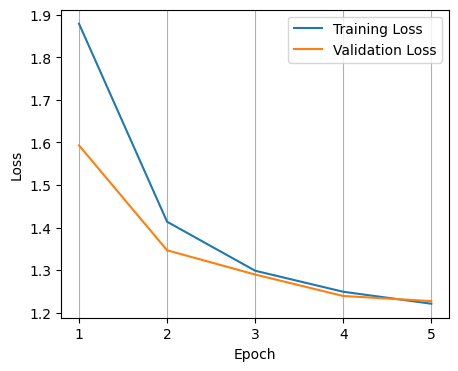

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:02<00:00, 42.95it/s, test_loss=1.09426]


Test Loss: 1.09426, Test Accuracy: 65.60%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:04<00:00, 35.84it/s, val_loss=1.20123]


Training Loss: 1.18486, Validation Loss: 1.20123, Validation Accuracy: 64.93%
Epsilon = 2.00, Target-Epsilon = 2.0, Target-Delta = 1e-06
Total training time: 00:12:35


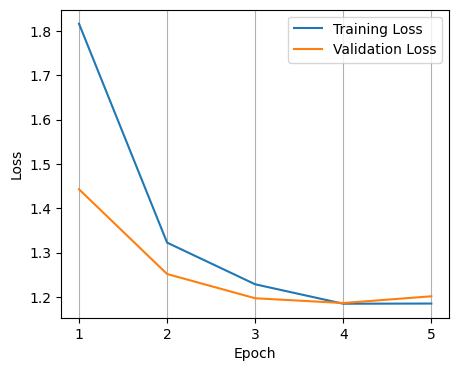

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:02<00:00, 41.93it/s, test_loss=1.07075]


Test Loss: 1.07075, Test Accuracy: 68.08%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Training-Epoch 1/5:  10%|█▉                  | 134/1407 [00:14<02:09,  9.80it/s, train_loss=2.16889]

In [ ]:
# parameters
import gc
epsilon_list=[0.5,1.0,1.5,2.0, 4.0]#, 8.0]
delta_list=[1]
max_grad_norm_list=[10.0]
noise_multiplier_list= [1,1.5,2.5,3.5,4.5]

# Make_private_with_epsilon (use_targets=True)
for epsilon in epsilon_list:
  torch.cuda.empty_cache()

  # Model
  path_args = args_1bc(medmnist.PathMNIST, num_classes=9, use_targets= True, target_epsilon=epsilon, target_delta=1e-6, max_grad_norm=10.0)
  train_loader, val_loader, test_loader = create_dataloader(path_args)
  model = create_model(path_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      path_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(path_args, test_loader, model)

  # Save
  name = "privacy_settings_path_epsilon"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()


#################### Testing with noise: 1.0 ########################
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:04<00:00, 36.31it/s, val_loss=1.21462]


Training Loss: 1.21500, Validation Loss: 1.21462, Validation Accuracy: 57.75%
Epsilon = 0.33, Target-Delta = 1e-06
Total training time: 00:12:35


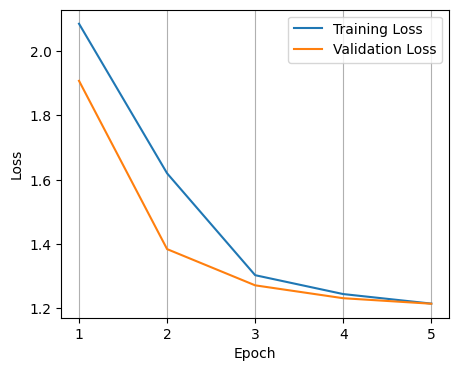

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:02<00:00, 41.72it/s, test_loss=1.02199]


Test Loss: 1.02199, Test Accuracy: 63.93%
Stats saved.
Figure saved.
#################### Testing with noise: 1.5 ########################
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:04<00:00, 35.62it/s, val_loss=1.17718]


Training Loss: 1.18001, Validation Loss: 1.17718, Validation Accuracy: 57.54%
Epsilon = 0.18, Target-Delta = 1e-06
Total training time: 00:12:40


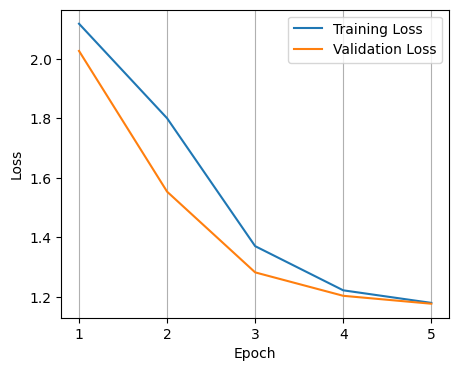

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:02<00:00, 40.42it/s, test_loss=0.95359]


Test Loss: 0.95359, Test Accuracy: 65.22%
Stats saved.
Figure saved.
#################### Testing with noise: 2.5 ########################
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:04<00:00, 33.02it/s, val_loss=1.27912]
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Training Loss: 1.32839, Validation Loss: 1.27912, Validation Accuracy: 51.57%
Epsilon = 0.10, Target-Delta = 1e-06
Total training time: 00:12:37


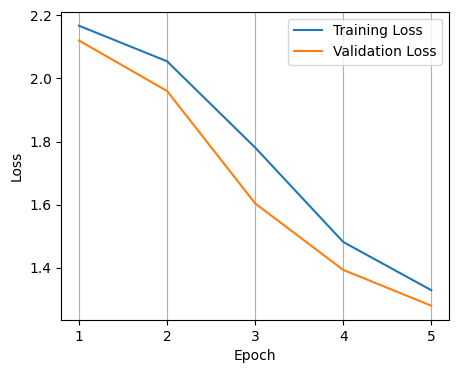

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:03<00:00, 30.60it/s, test_loss=1.11212]


Test Loss: 1.11212, Test Accuracy: 58.91%
Stats saved.
Figure saved.
#################### Testing with noise: 3.5 ########################
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:05<00:00, 30.86it/s, val_loss=1.58146]


Training Loss: 1.64439, Validation Loss: 1.58146, Validation Accuracy: 43.60%
Epsilon = 0.07, Target-Delta = 1e-06
Total training time: 00:12:38


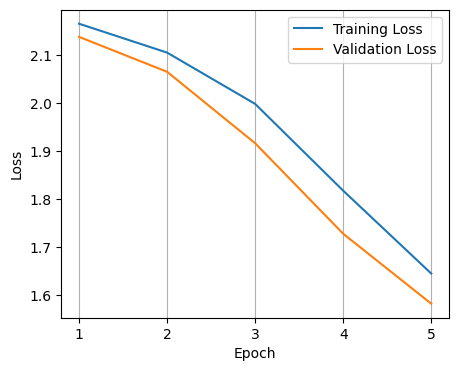

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:03<00:00, 33.43it/s, test_loss=1.34213]


Test Loss: 1.34213, Test Accuracy: 50.02%
Stats saved.
Figure saved.
#################### Testing with noise: 4.5 ########################
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|█████████████████████| 157/157 [00:03<00:00, 41.24it/s, val_loss=1.85295]


Training Loss: 1.91753, Validation Loss: 1.85295, Validation Accuracy: 37.67%
Epsilon = 0.06, Target-Delta = 1e-06
Total training time: 00:12:32


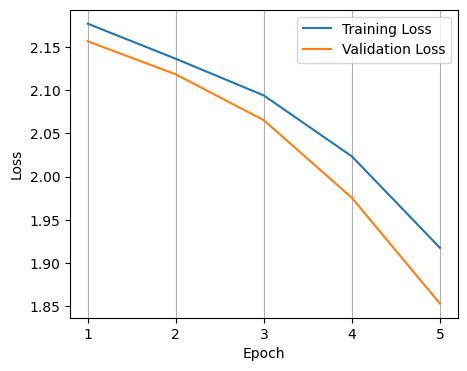

Device: cuda


Test-Loop: 100%|███████████████████████████████| 113/113 [00:02<00:00, 40.37it/s, test_loss=1.71707]


Test Loss: 1.71707, Test Accuracy: 50.40%
Stats saved.
Figure saved.


In [ ]:
#make_private(use_targets=False)
import gc
noise_multiplier_list= [1.0,1.5,2.5,3.5,4.5]
for noise in noise_multiplier_list:
  print(f"#################### Testing with noise: {noise} ########################")
  torch.cuda.empty_cache()

  # Model
  path_args = args_1bc(medmnist.PathMNIST, num_classes=9, use_targets= False, target_delta=1e-6, max_grad_norm=20.0, noise_multiplier= noise)
  train_loader, val_loader, test_loader = create_dataloader(path_args)
  model = create_model(path_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      path_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(breast_args, test_loader, model)

  # Save
  name = "privacy_settings_path_noise"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()


# Make_Private_Epsilon_Derma_Dataset

Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz


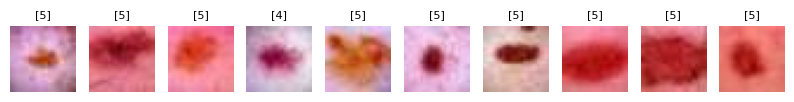

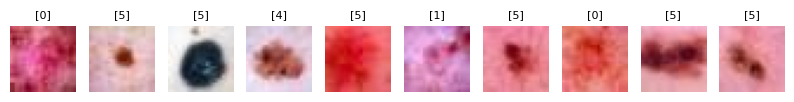

In [ ]:
# Data
train_loader, val_loader, test_loader = create_dataloader(derma_args)
sample_data(train_loader)

Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.

Device: cuda


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
Training-Epoch 1/5:   0%|                                                   | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and 

Training Loss: 1.20491, Validation Loss: 1.19109, Validation Accuracy: 66.86%
Epsilon = 0.49, Target-Epsilon = 0.5, Target-Delta = 1e-06
Total training time: 00:01:06


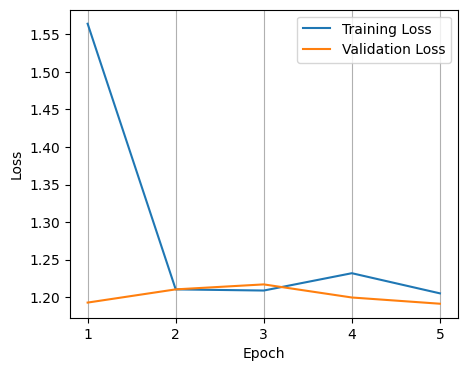

Device: cuda


Test-Loop: 100%|█████████████████████████████████| 32/32 [00:01<00:00, 23.92it/s, test_loss=1.21325]


Test Loss: 1.21325, Test Accuracy: 66.78%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|███████████████████████| 16/16 [00:00<00:00, 21.87it/s, val_loss=1.17633]


Training Loss: 1.18609, Validation Loss: 1.17633, Validation Accuracy: 66.86%
Epsilon = 1.00, Target-Epsilon = 1.0, Target-Delta = 1e-06
Total training time: 00:01:12


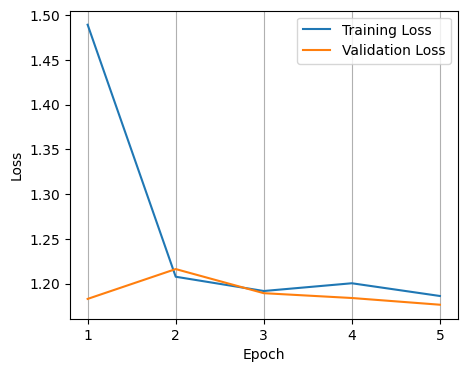

Device: cuda


Test-Loop: 100%|█████████████████████████████████| 32/32 [00:00<00:00, 37.08it/s, test_loss=1.20180]


Test Loss: 1.20180, Test Accuracy: 66.78%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|███████████████████████| 16/16 [00:00<00:00, 37.12it/s, val_loss=1.17360]


Training Loss: 1.18489, Validation Loss: 1.17360, Validation Accuracy: 66.86%
Epsilon = 1.50, Target-Epsilon = 1.5, Target-Delta = 1e-06
Total training time: 00:01:03


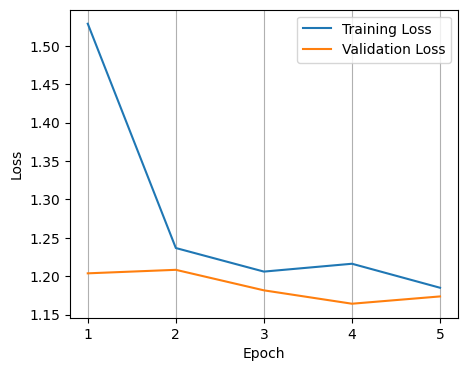

Device: cuda


Test-Loop: 100%|█████████████████████████████████| 32/32 [00:00<00:00, 39.45it/s, test_loss=1.20239]


Test Loss: 1.20239, Test Accuracy: 66.78%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Device: cuda


Validation-Epoch 5/5: 100%|███████████████████████| 16/16 [00:00<00:00, 33.10it/s, val_loss=1.17181]


Training Loss: 1.17815, Validation Loss: 1.17181, Validation Accuracy: 66.86%
Epsilon = 2.00, Target-Epsilon = 2.0, Target-Delta = 1e-06
Total training time: 00:01:05


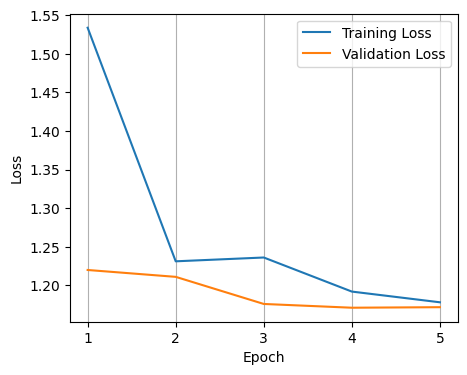

Device: cuda


Test-Loop: 100%|█████████████████████████████████| 32/32 [00:00<00:00, 32.39it/s, test_loss=1.20052]


Test Loss: 1.20052, Test Accuracy: 66.78%
Stats saved.
Figure saved.
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Using downloaded and verified file: ./data/dermamnist.npz
Device: cuda


Training-Epoch 5/5:  30%|██████▌               | 33/110 [00:03<00:08,  8.83it/s, train_loss=1.18581]

In [ ]:
# parameters
import gc
epsilon_list=[0.5,1.0,1.5,2.0, 4.0]#, 8.0]
delta_list=[1]
max_grad_norm_list=[10.0]
noise_multiplier_list= [1,1.5,2.5,3.5,4.5]

# Make_private_with_epsilon (use_targets=True)
for epsilon in epsilon_list:
  torch.cuda.empty_cache()

  # Model
  derma_args = args_1bc(medmnist.DermaMNIST, num_classes=9, use_targets= True, target_epsilon=epsilon, target_delta=1e-6, max_grad_norm=10.0)
  train_loader, val_loader, test_loader = create_dataloader(derma_args)
  model = create_model(derma_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      derma_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(derma_args, test_loader, model)

  # Save
  name = "privacy_settings_derma_epsilon"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()

In [ ]:
#make_private(use_targets=False)
noise_multiplier_list= [10,1.5,2.5,3.5,4.5]
for noise in noise_multiplier_list:
  print(f"#################### Testing with noise: {noise} ########################")
  torch.cuda.empty_cache()

  # Model
  derma_args = args_1bc(medmnist.DermaMNIST, num_classes=9, use_targets= False, target_delta=1e-6, max_grad_norm=20.0, noise_multiplier= noise)
  train_loader, val_loader, test_loader = create_dataloader(derma_args)
  model = create_model(derma_args)

  # Training
  model, train_loss, val_loss, val_acc, fig = training(
      derma_args, train_loader, val_loader, model,
      use_privacy_engine=True # Use DP privatization during training or not
      )
  plt.figure(fig)
  plt.show(fig)

  # Test
  test_loss, test_acc = test(derma_args, test_loader, model)

  # Save
  name = "privacy_settings_derma_noise"
  stats = dict(
      train_loss=train_loss,
      val_loss=val_loss,
      val_acc=val_acc,
      test_loss=test_loss,
      test_acc=test_acc
  )
  save_stats(stats, name)
  save_fig(fig, name)
  model=None
  gc.collect()

# Figures make_private_epsilon

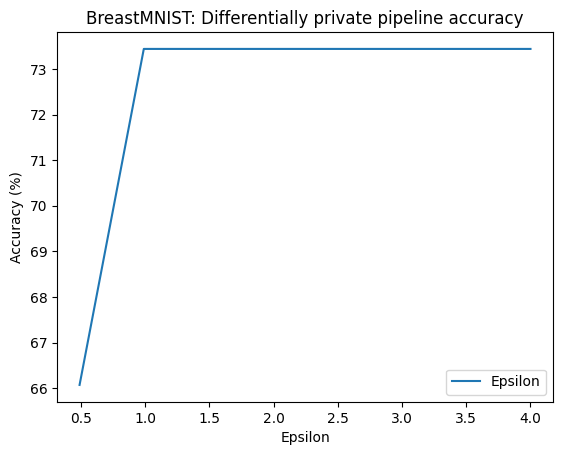

In [ ]:
#breast_dataset_acc
acc_eps= [66.07, 73.44, 73.44, 73.44, 73.44]
epsilon_list_x= [0.49, 0.99, 1.49, 2.0, 4.0]

plt.plot( epsilon_list_x, acc_eps,label="Epsilon")
plt.title("BreastMNIST: Differentially private pipeline accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()

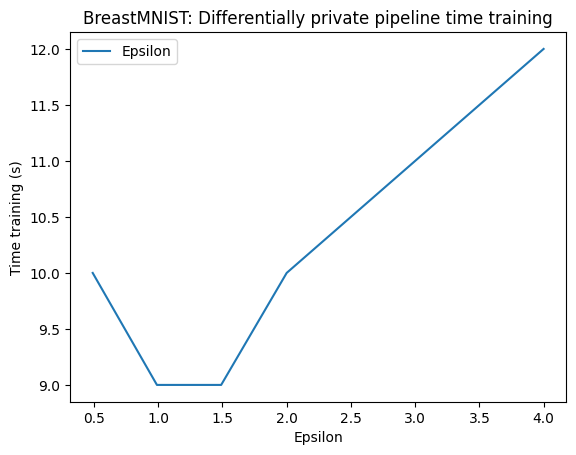

In [ ]:
#breast_dataset_time_training
time_training_breast= [10.0, 9.0, 9.0, 10.0, 12.0] #in seconds
epsilon_list_x= [0.49, 0.99, 1.49, 2.0, 4.0]

plt.plot( epsilon_list_x, time_training_breast, label="Epsilon")
plt.title("BreastMNIST: Differentially private pipeline time training")
plt.xlabel("Epsilon")
plt.ylabel("Time training (s)")
plt.legend()

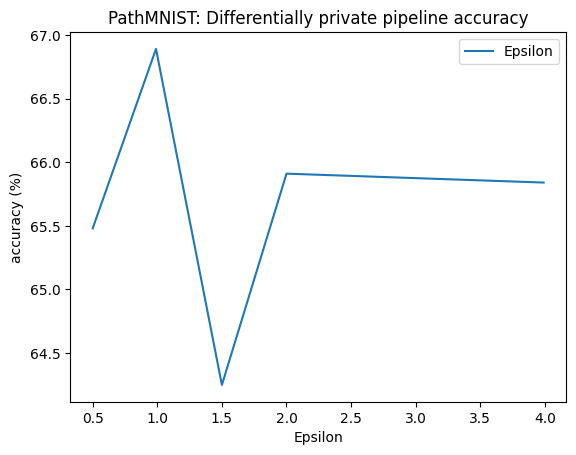

In [ ]:
#path_dataset_acc
epsilon_list_x= [0.5, 0.99, 1.50, 2.0, 3.99]
acc_list_path= [65.48, 66.89, 64.25, 65.91, 65.84]

plt.plot(epsilon_list_x, acc_list_path, label="Epsilon")
plt.title("PathMNIST: Differentially private pipeline accuracy")
plt.xlabel("Epsilon")
plt.ylabel("accuracy (%)")
plt.legend()

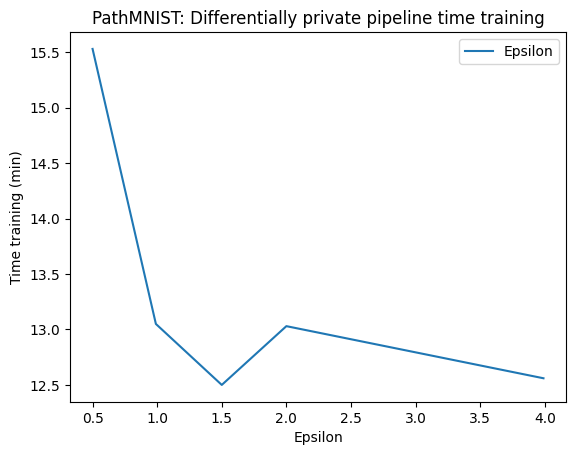

In [ ]:
#path_dataset_time_training
epsilon_list_x= [0.5, 0.99, 1.50, 2.0, 3.99]
time_training_path= [15.53, 13.05, 12.50, 13.03, 12.56]

plt.plot( epsilon_list_x, time_training_path,label="Epsilon")
plt.title("PathMNIST: Differentially private pipeline time training")
plt.xlabel("Epsilon")
plt.ylabel("Time training (min)")
plt.legend()

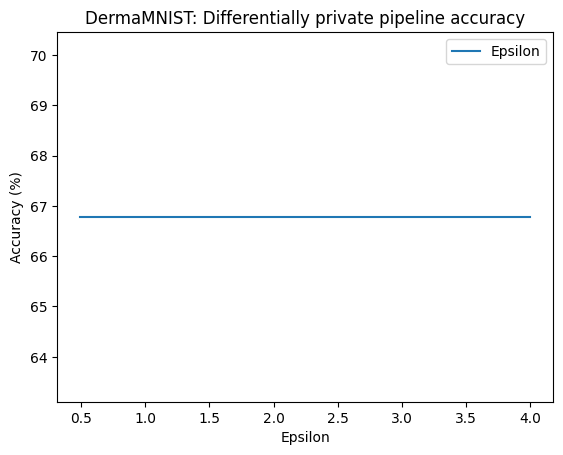

In [ ]:
#derma_dataset_acc
epsilon_list_x= [0.49, 1.00, 1.50, 2.00, 4.00]
acc_list_derma= [66.78, 66.78, 66.78, 66.78, 66.78]

plt.plot( epsilon_list_x, acc_list_derma,label="Epsilon")
plt.title("DermaMNIST: Differentially private pipeline accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()

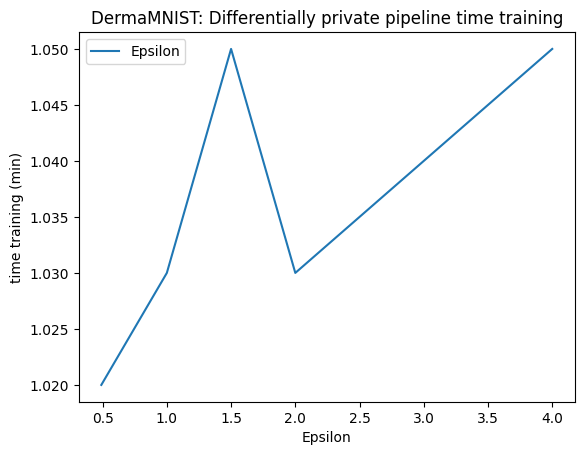

In [ ]:
#derma_dataset_time_training
epsilon_list_x= [0.49, 1.00, 1.50, 2.00, 4.00]
time_derma= [1.02, 1.03, 1.05, 1.03, 1.05]

plt.plot( epsilon_list_x, time_derma, label="Epsilon")
plt.title("DermaMNIST: Differentially private pipeline time training")
plt.xlabel("Epsilon")
plt.ylabel("time training (min)")
plt.legend()

# Figures make_private_noise_multiplier

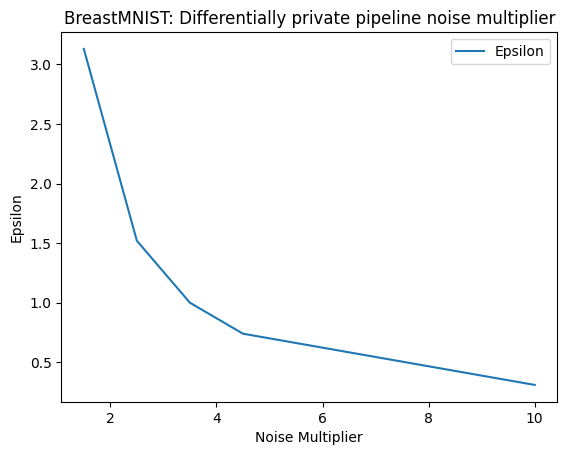

In [ ]:
#breast_dataset_acc
epsilon_list_y_noise= [3.13, 1.52, 1.00, 0.74,0.31]
noise_list_x= [1.5,2.5,3.5,4.5,10]
plt.plot( noise_list_x, epsilon_list_y_noise,label="Epsilon")
plt.title("BreastMNIST: Differentially private pipeline noise multiplier")
plt.xlabel("Noise Multiplier")
plt.ylabel("Epsilon")
plt.legend()


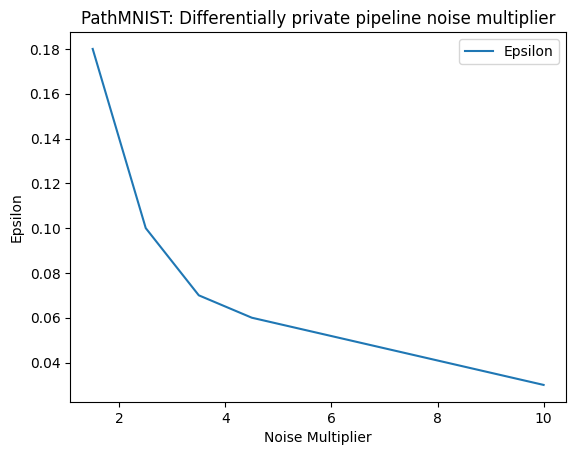

In [ ]:
#path_dataset_time_training
epsilon_list_y_noise= [0.18,0.10, 0.07, 0.06,0.03]
noise_list_x= [1.5,2.5,3.5,4.5,10]
plt.plot( noise_list_x, epsilon_list_y_noise, label="Epsilon")
plt.title("PathMNIST: Differentially private pipeline noise multiplier")
plt.xlabel("Noise Multiplier")
plt.ylabel("Epsilon")
plt.legend()

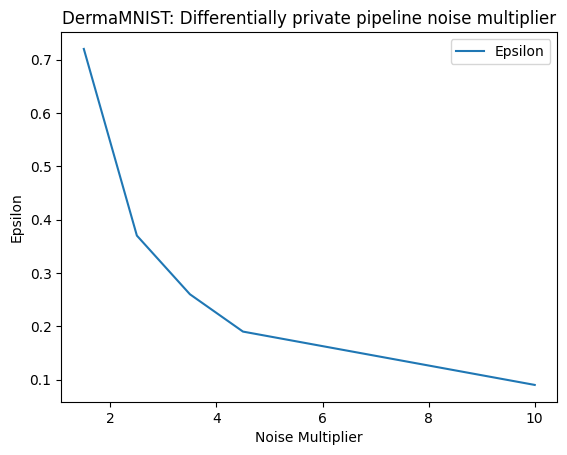

In [ ]:
#derma_dataset
epsilon_list_y_noise= [ 0.72, 0.37, 0.26, 0.19,0.09]
noise_list_x_derma= [1.5,2.5,3.5,4.5,10]
plt.plot( noise_list_x_derma, epsilon_list_y_noise, label="Epsilon")
plt.title("DermaMNIST: Differentially private pipeline noise multiplier")
plt.xlabel("Noise Multiplier")
plt.ylabel("Epsilon")
plt.legend()